In [50]:
import tensorflow as tf
from tensorflow.keras import models, layers, Sequential
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')

In [43]:
def get_train_test_split_tf(ds,
                             train_split = 0.8,
                             val_split = 0.1,
                             shuffle = True,
                             shuffle_size = 500):
    
    ds_size = len(ds)
    
    if shuffle:
        
        ds = ds.shuffle(shuffle_size,seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [12]:
!ls ../data

Potato___Early_blight  Potato___healthy  Potato___Late_blight


In [13]:
IMG_SIZE = 256
BATCH_SIZE = 32

In [14]:
dataset = tf.keras.preprocessing.image_dataset_from_directory('../data',
                                                              shuffle = True,
                                                              image_size = (IMG_SIZE,IMG_SIZE),
                                                              batch_size = BATCH_SIZE
                                                             )

Found 2152 files belonging to 3 classes.


In [17]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [18]:
len(dataset)

68

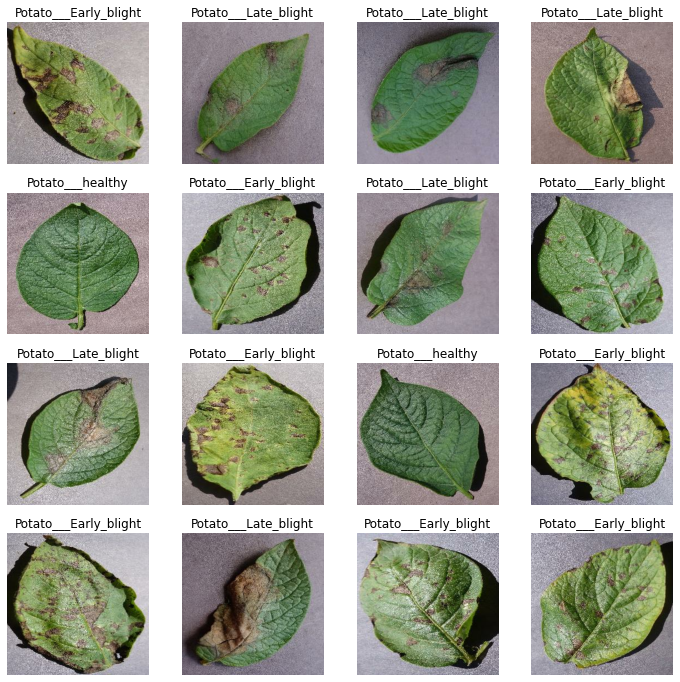

In [38]:
for img_batch,label_batch in dataset.take(1):
    plt.figure(figsize=(12,12))
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.title(class_names[label_batch[i]])
        plt.imshow(img_batch[i].numpy().astype('uint'))
        plt.axis('off')

In [45]:
train_ds,val_ds,test_ds = get_train_test_split_tf(dataset)

In [46]:
len(train_ds)

54

In [47]:
len(val_ds)

6

In [48]:
len(test_ds)

8

In [49]:
train_ds = train_ds.cache().shuffle(500).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(500).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(500).prefetch(buffer_size = tf.data.AUTOTUNE)

In [53]:
resize_and_rescale = Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [54]:
data_augmentation = Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
test_image_batch,labels = train_ds.take(1)

In [55]:
input_shape = (BATCH_SIZE,IMG_SIZE,IMG_SIZE,CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation = 'relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu',),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(n_classe,activation = 'softmax')
])

NameError: name 'CHANNELS' is not defined